In [37]:

import os
from detanet_model import *

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = []
spec_data = []

# Load the dataset
dataset = torch.load(os.path.join(data_dir, 'KITqm9_dataset.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

print(f"Total dataset length: {len(dataset)}")

ex1 = dataset[0]
ex2 = dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in dataset:
    data.y = torch.cat([data.real, data.imag], dim=0)
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 5159
Total dataset length: 5159
dataset[0] : Data(pos=[7, 3], idx='KITQM9_34', dataset_name='KITQM9', smiles='OCC#N', polarizability_type='ee', z=[7], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[5] : Data(pos=[9, 3], idx='KITQM9_331', dataset_name='KITQM9', smiles='NC(C#N)C#N', polarizability_type='ee', z=[9], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[0] : Data(pos=[7, 3], idx='KITQM9_34', dataset_name='KITQM9', smiles='OCC#N', polarizability_type='ee', z=[7], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3], x=[7, 62])


In [2]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [3]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=3, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=16,
                    rc=3,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params='/media/maria/work_space/dyn-detanet/code/trained_param/pretty-sweep_polar_Falsenormalize_70epochs_32bs_0_0006855550241449846lr_3blocks.pth'
state_dict = torch.load(params)
model.to(device)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch


# ---------- helpers -----------------------------------------------------------
def minmax_scale(arr):
    """Scale to [0, 1]; if all values equal → zeros."""
    arr = np.asarray(arr, dtype=float)
    amin, amax = arr.min(), arr.max()
    return np.zeros_like(arr) if abs(amax - amin) < 1e-15 else (arr - amin) / (amax - amin)


def _split_real_imag(pred_tensor):
    real = pred_tensor[:62,:,:]          # [:, :, 0]  [:, :, 1]  [:, :, 2]
    imag = pred_tensor[62:,:,:]
    return real, imag


# ---------- main --------------------------------------------------------------
def plot_polarizability_matrix_3x3(data_entry, model, out_dir=".", symmetric=True):
    """
    Makes two figures per molecule:
      • 3×3 real-part GT vs prediction
      • 3×3 imag-part GT vs prediction
    Output files:
      polar_real_<mol-idx>_<dataset>.png
      polar_imag_<mol-idx>_<dataset>.png
    """

    # Ensure output folder exists
    os.makedirs(out_dir, exist_ok=True)

    # --------------------- fetch GT -------------------------------------------
    gt_real = np.asarray(data_entry.real)   # [N,3,3]
    gt_imag = np.asarray(data_entry.imag)   # [N,3,3]
    freqs   = np.asarray(data_entry.freqs)  # [N]

    # --------------------- predictions ---------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()

    with torch.no_grad():
        pred = model(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
            x_features=data_entry.x.to(device)
        ).cpu().numpy()                    # [N,3,6]

    pred_real, pred_imag = _split_real_imag(pred)  # both [N,3,3]
    print(f"GT shape: {gt_real.shape}, Pred shape: {pred_real.shape}")

    # -------------------------------------------------------------------------
    def _plot_one_part(gt, pred, part_name, fprefix):
        """Helper: draw a single 3×3 grid (either real or imag)."""
        fig, axes = plt.subplots(3, 3, figsize=(11, 9), sharex=True, sharey=False)
        fig.suptitle(f"{part_name.capitalize()} Polarizability – Mol {data_entry.idx}", fontsize=14)

        pairs = [(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]
        labels = ["xx", "xy", "xz", "yy", "yz", "zz"]

        # global min-max
        flat = np.hstack([
            gt[:, i, j].ravel()          # GT real
            for (i, j) in pairs
        ] + [
            pred[:, i, j].ravel()      # pred real
            for (i, j) in pairs
        ])
        min, max = flat.min(), flat.max()

        for r in range(3):
            for c in range(3):
                ax = axes[r, c]

                # grey the redundant lower-triangle when symmetric
                if symmetric and r > c:
                    ax.add_patch(
                        mpatches.Rectangle((freqs.min(), 0),
                                           freqs.max() - freqs.min(), 1,
                                           transform=ax.get_xaxis_transform(),
                                           color="lightgrey", zorder=0)
                    )

                gt_vals   = gt[:, r, c]
                pred_vals = pred[:, r, c]

                ax.plot(freqs, gt_vals,   'o', ms=3, color='royalblue',   alpha=0.7,
                        label="Ground Truth"   if (r, c) == (0, 0) else None)
                ax.plot(freqs, pred_vals, 'o', ms=3, color='tab:orange', alpha=0.7,
                        label="Prediction" if (r, c) == (0, 0) else None)
                ax.set_ylim(min, max)
                ax.set_xlim(freqs.min(), freqs.max())
                ax.set_title(f"({r},{c})", fontsize=10)
                if r == 2:
                    ax.set_xlabel("Frequency (eV)")
                if c == 0:
                    ax.set_ylabel("Intensity")

        # single consolidated legend
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', frameon=False)

        plt.tight_layout(rect=[0, 0, 0.97, 0.95])
        fname = os.path.join(out_dir,
                             f"{fprefix}_{data_entry.idx}_{data_entry.dataset_name}.png")
        plt.savefig(fname, dpi=300)
        plt.show()
        plt.close(fig)

    # ------------------------- draw & save ------------------------------------
    _plot_one_part(gt_real, pred_real, "real", "polar_real")
    _plot_one_part(gt_imag, pred_imag, "imag", "polar_imag")


GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


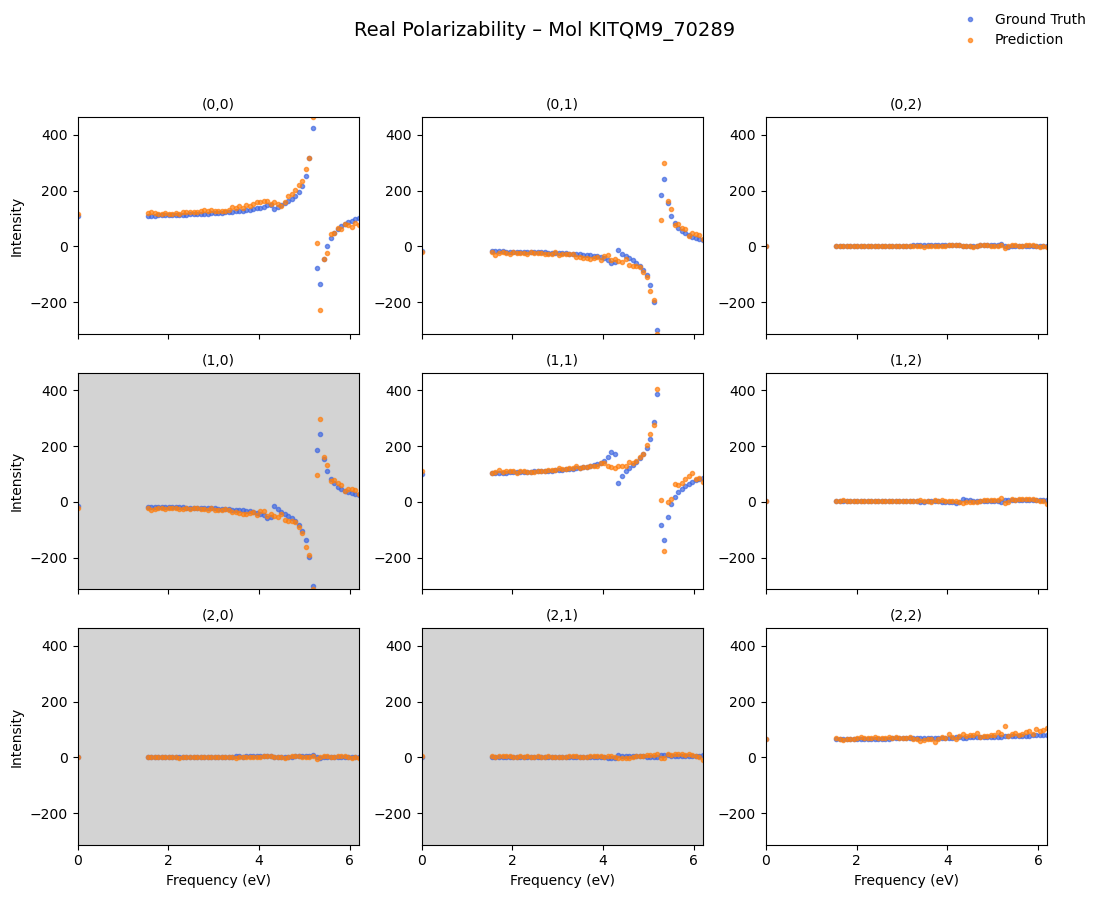

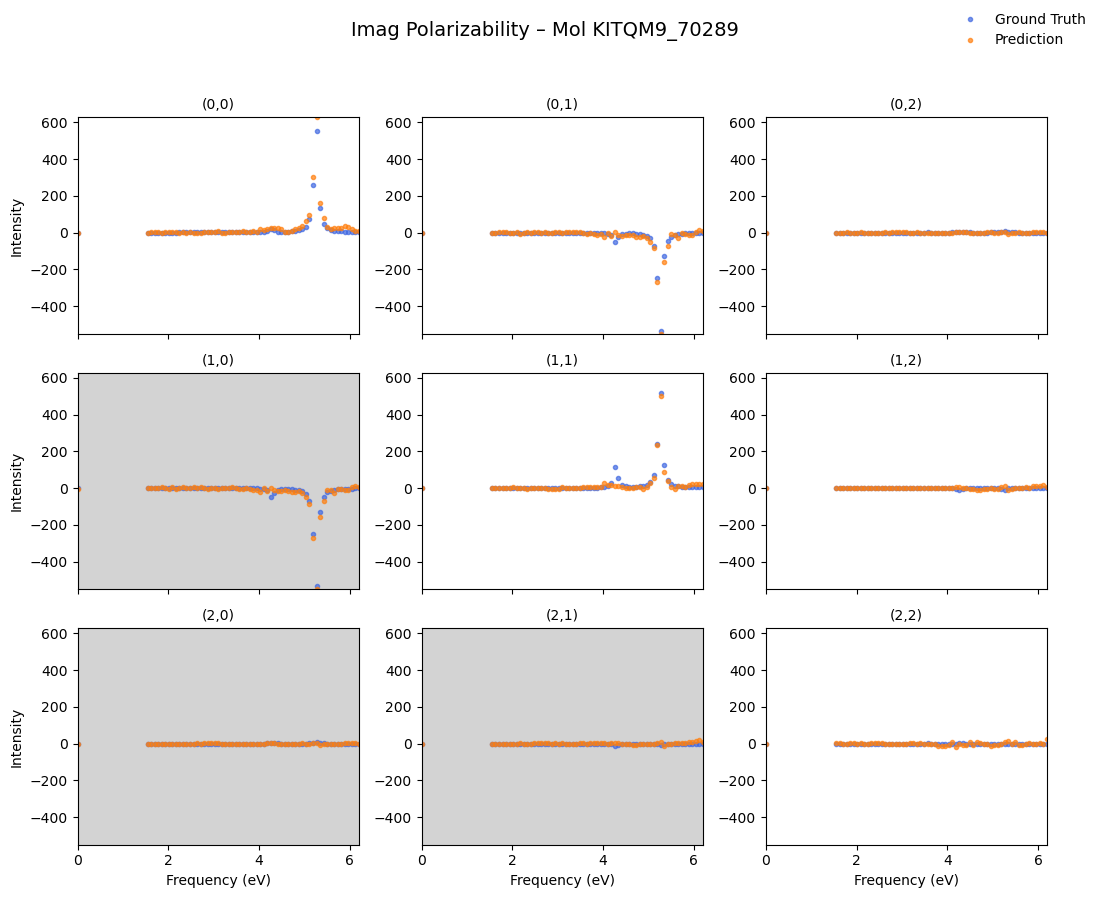

GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


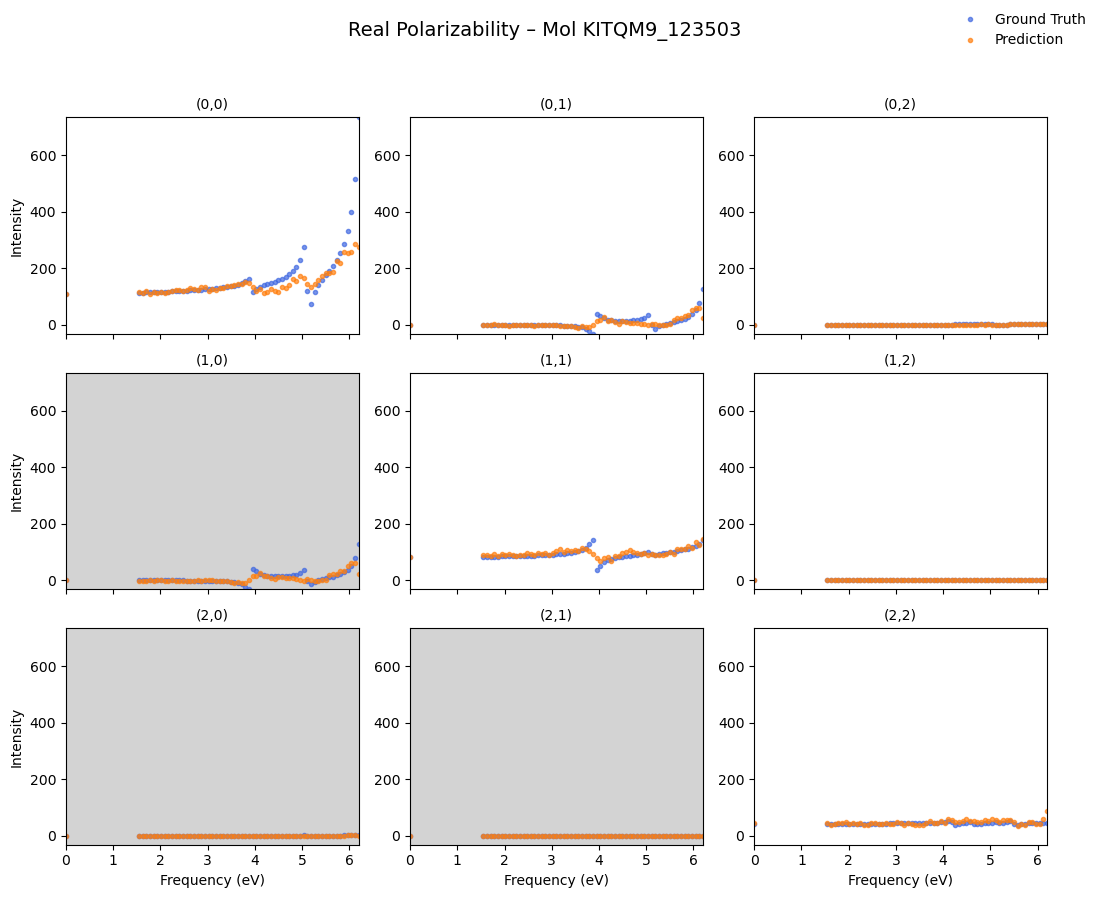

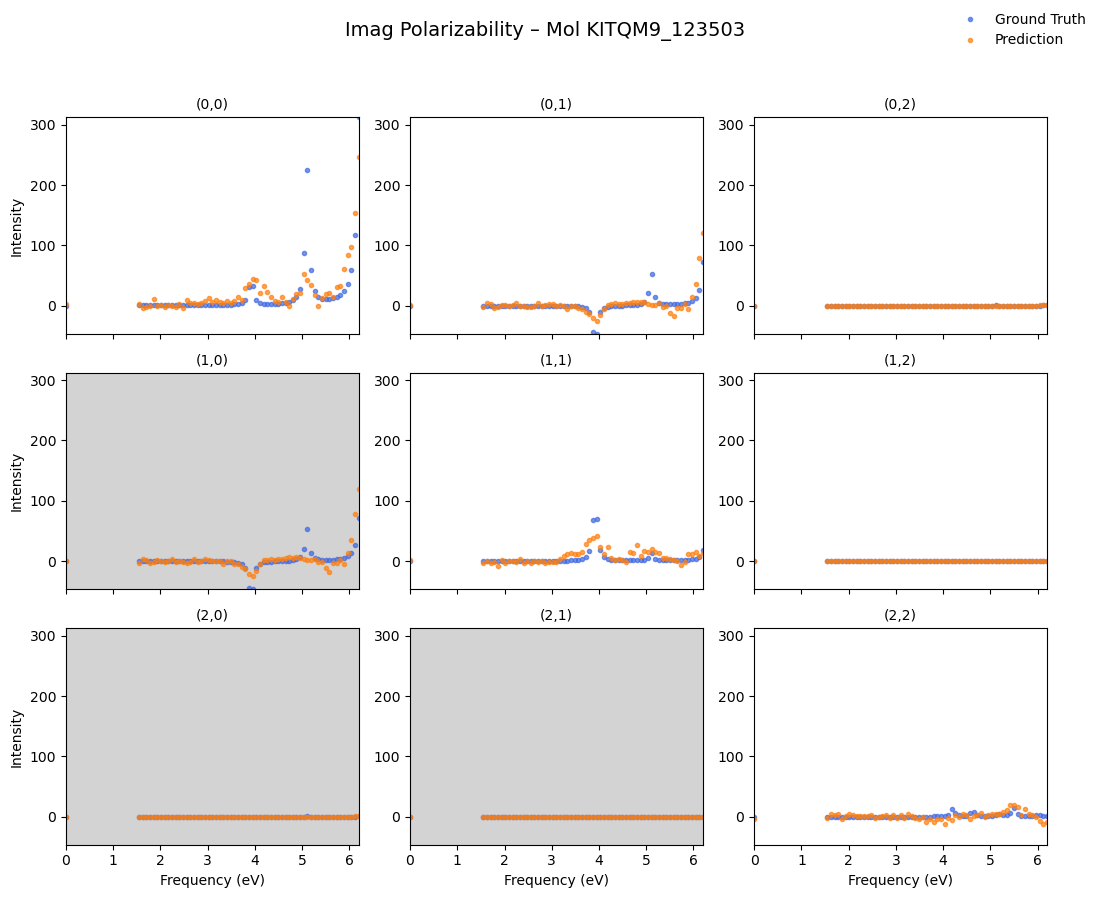

GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


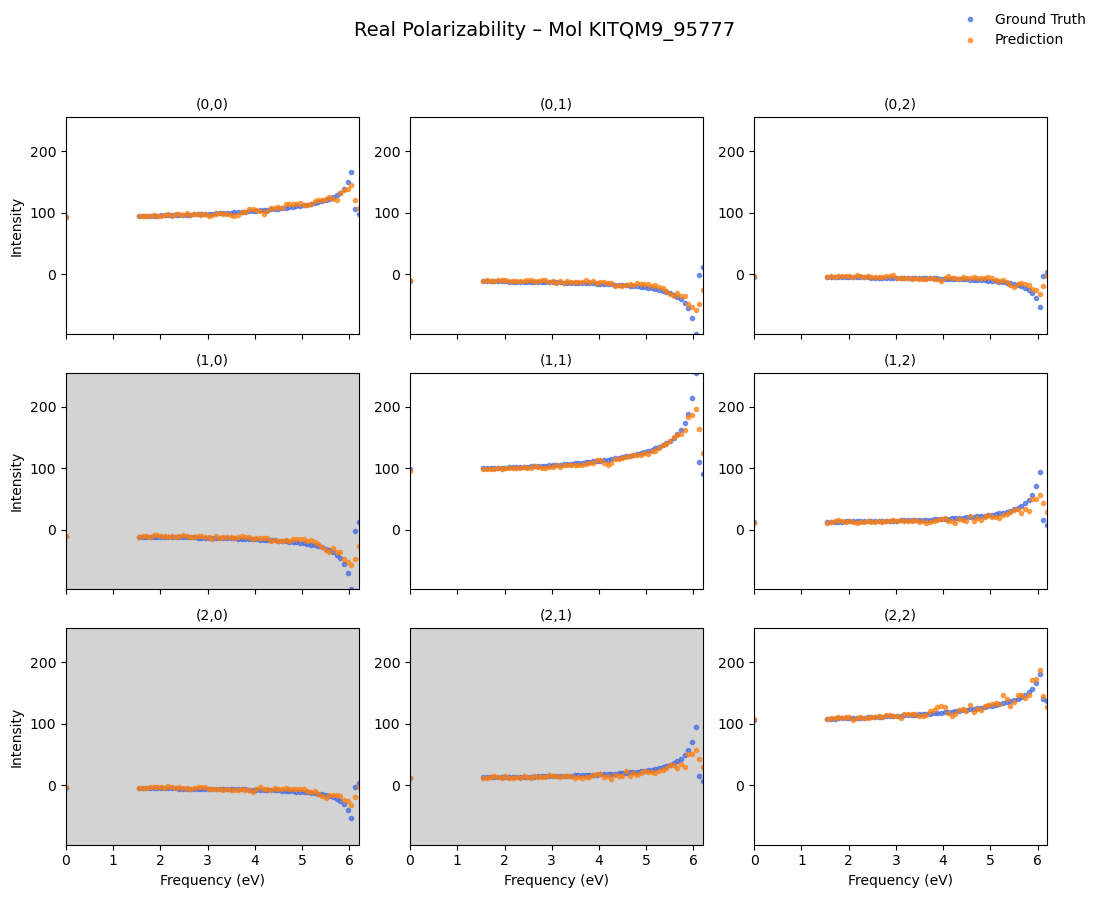

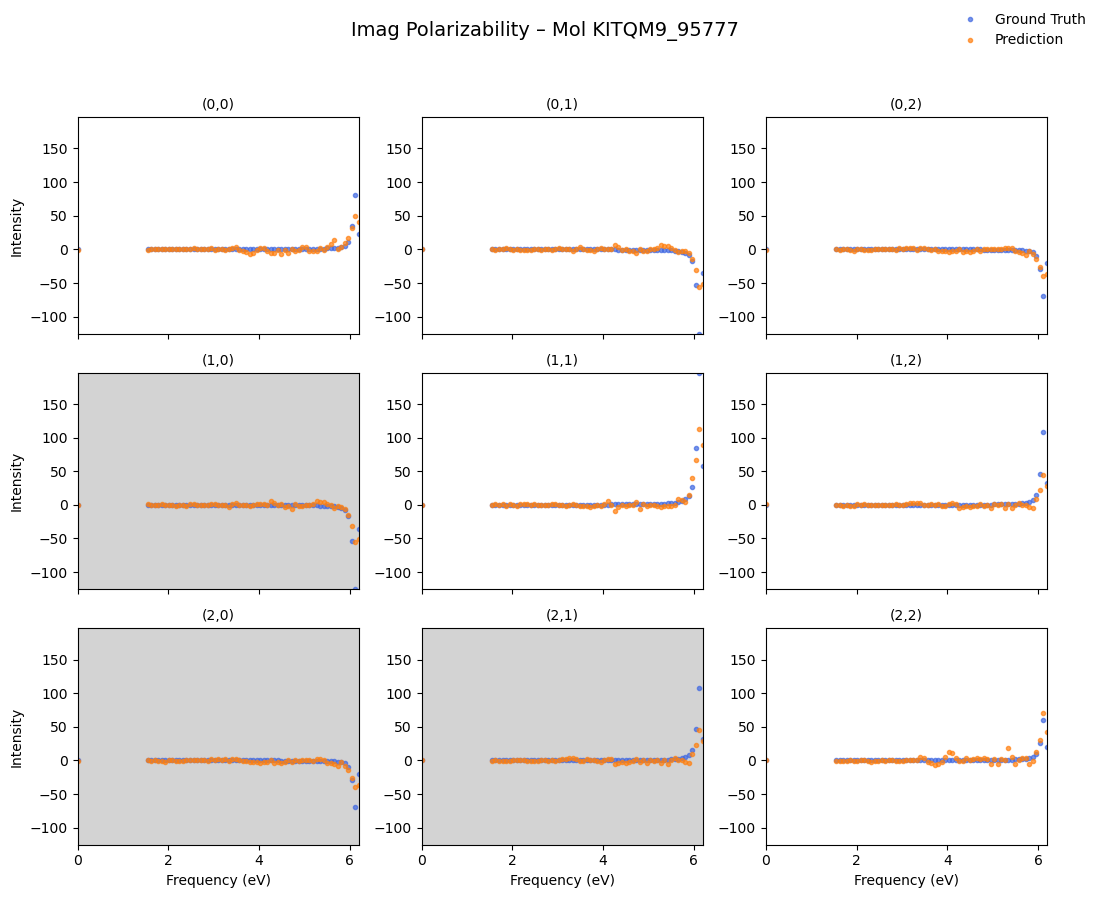

GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


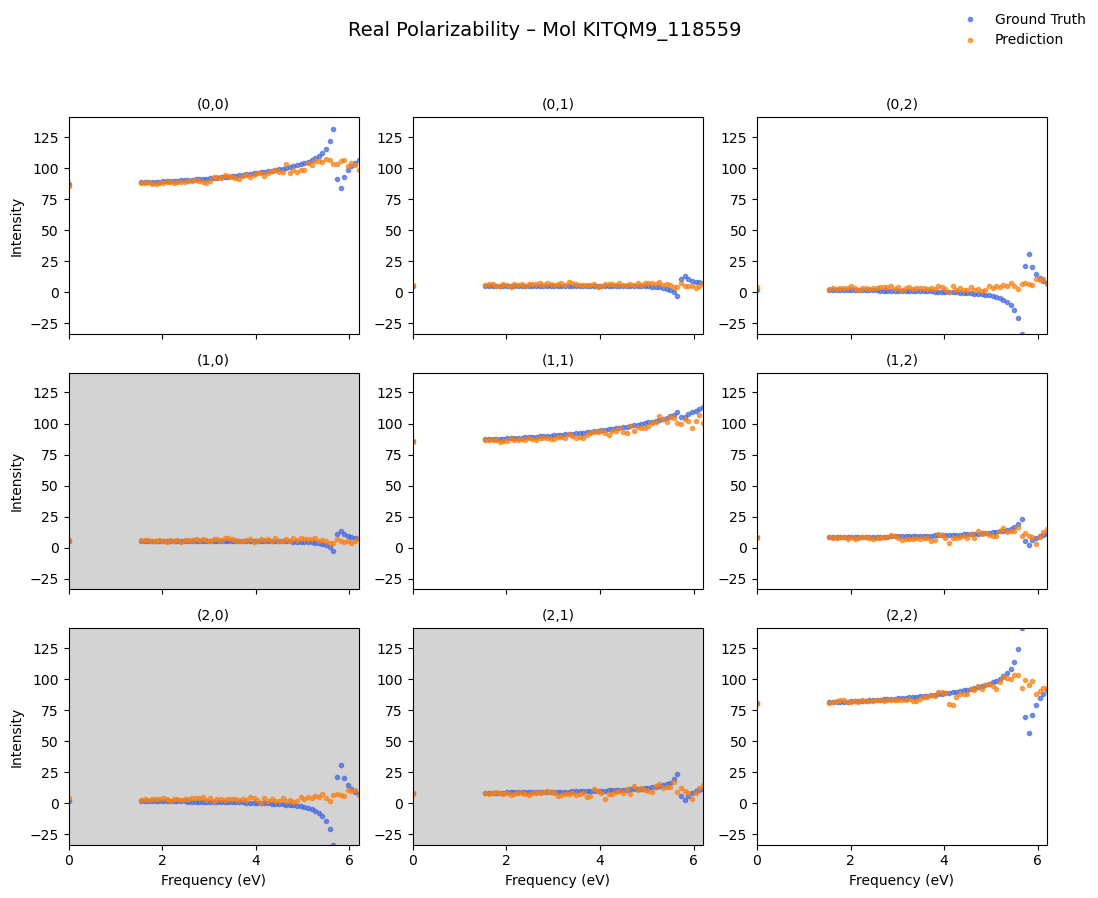

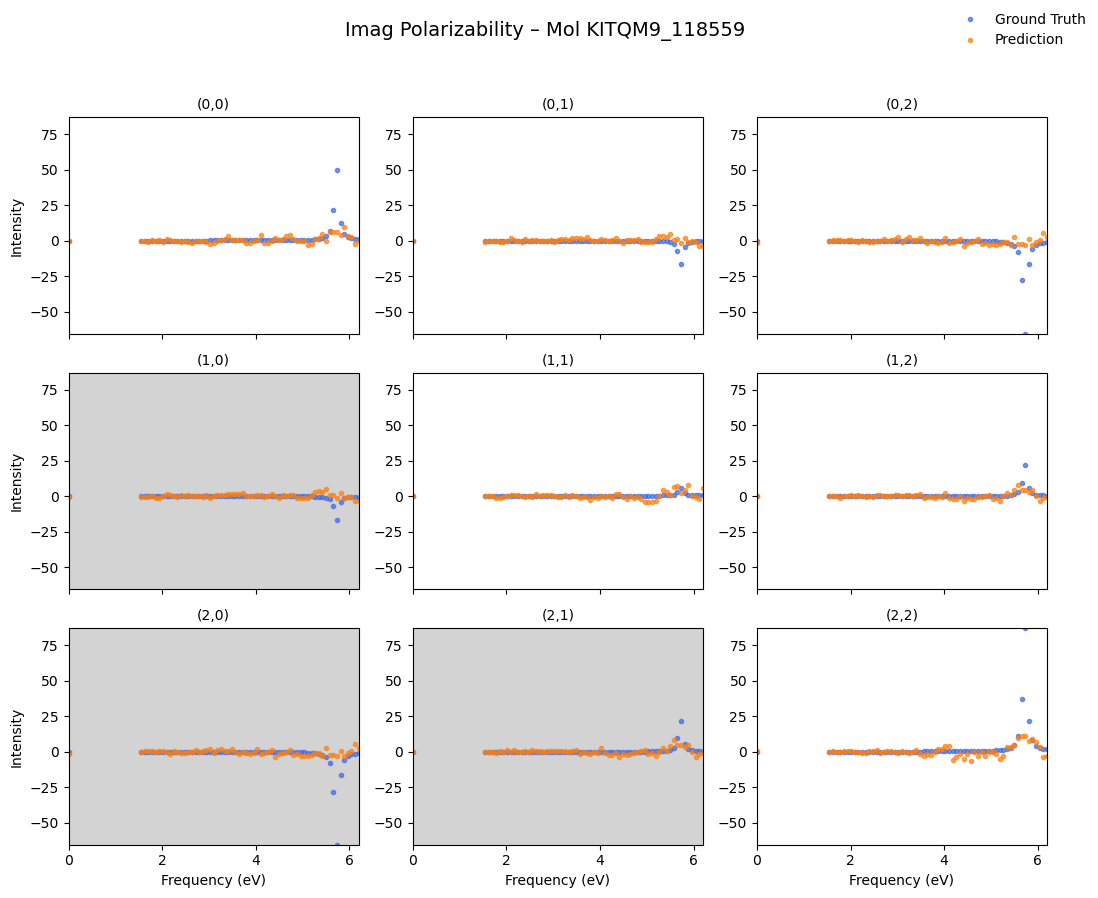

In [17]:
for i in range(4):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry

    plot_polarizability_matrix_3x3(data_entry ,model, out_dir="/media/maria/work_space/detanet-complex/images/OPT_pred_molcules")

# HOPV Dataset

In [38]:

import os
from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader

import trainer
from detanet_model import *

import wandb
import random
random.seed(42)

batch_size = 64
epochs = 100
lr=5e-4
cutoff=5.0
num_block=3
num_features=128

finetune = False
# -------------------------------

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

HOPV_dataset = []
spec_data = []

# Load the dataset
HOPV_dataset = torch.load(os.path.join(data_dir, 'HOPV_dataset.pt'))
print(f"Number of graphs in the dataset: {len(HOPV_dataset)}")

print(f"Total dataset length: {len(HOPV_dataset)}")

ex1 = HOPV_dataset[0]
ex2 = HOPV_dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in HOPV_dataset:
    data.y = torch.cat([data.real, data.imag], dim=0)
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = HOPV_dataset[0]
print("dataset[0] :", ex1, )





Number of graphs in the dataset: 347
Total dataset length: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', polarizability_type='ee', z=[68], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[5] : Data(pos=[55, 3], idx='HOPV_5', dataset_name='HOPV', smiles='C#Cc1cc(OC)c(C#Cc2scc3nc(-c4ccccc4)c(-c4ccccc4)nc32)cc1OC', polarizability_type='ee', z=[55], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', polarizability_type='ee', z=[68], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3], x=[68, 62])


In [39]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(HOPV_dataset)
train_frac = 0.9
split_index = int(train_frac * len(HOPV_dataset))

HOPV_train_datasets = HOPV_dataset[:split_index]
HOPV_val_datasets   = HOPV_dataset[split_index:]


In [40]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_HOPV = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=6, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=8,
                    rc=10.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params='/media/maria/work_space/dyn-detanet/code/trained_param/Finetune_spectra_100epochs_8batchsize_0_0006lr_10cutoff_6numblock(1).pth'
state_dict = torch.load(params)
model_HOPV.to(device)
model_HOPV.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

HOPV_110
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


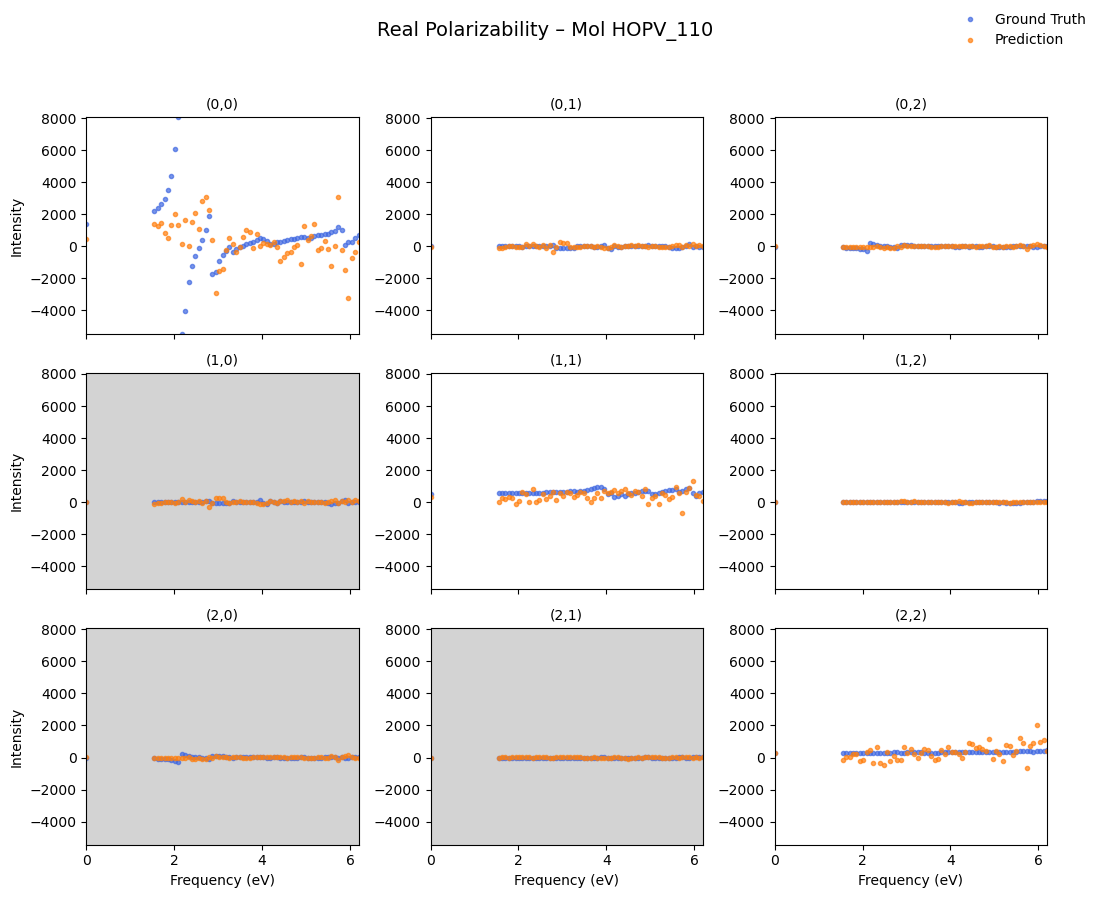

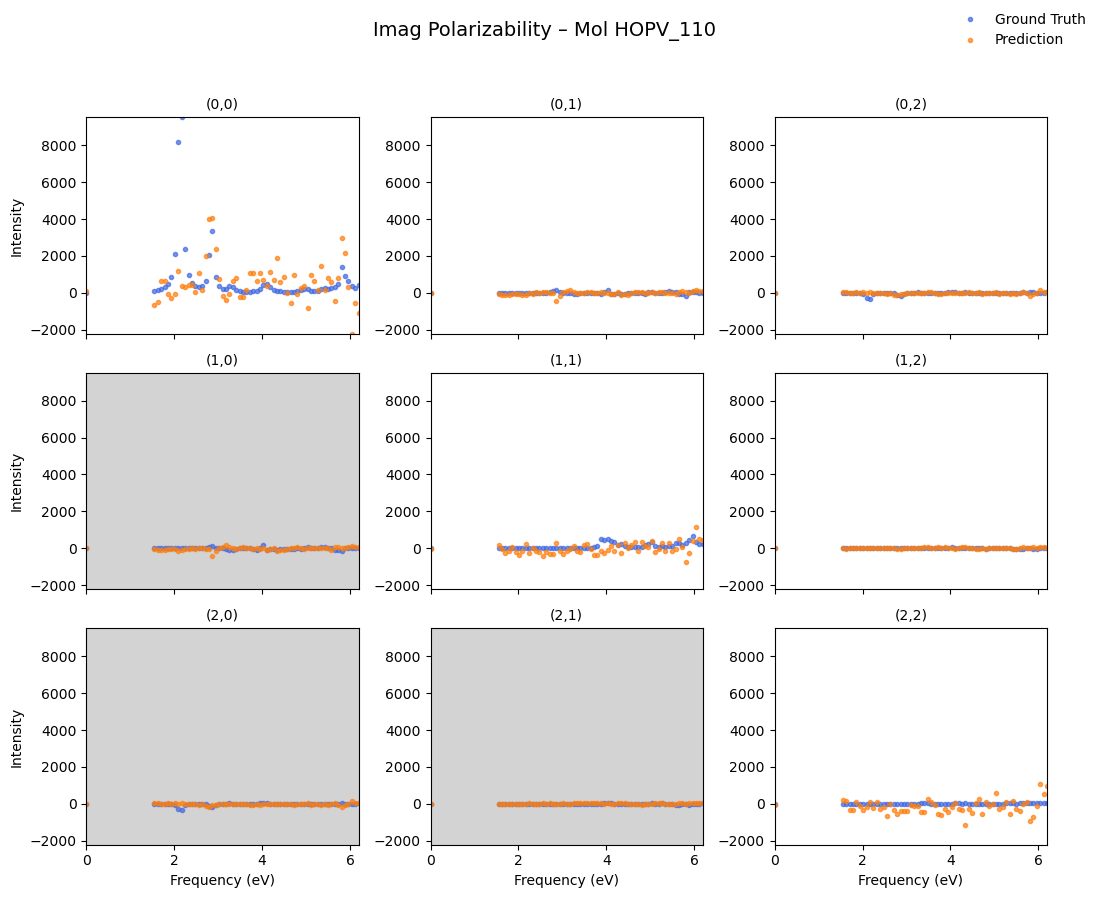

HOPV_79
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


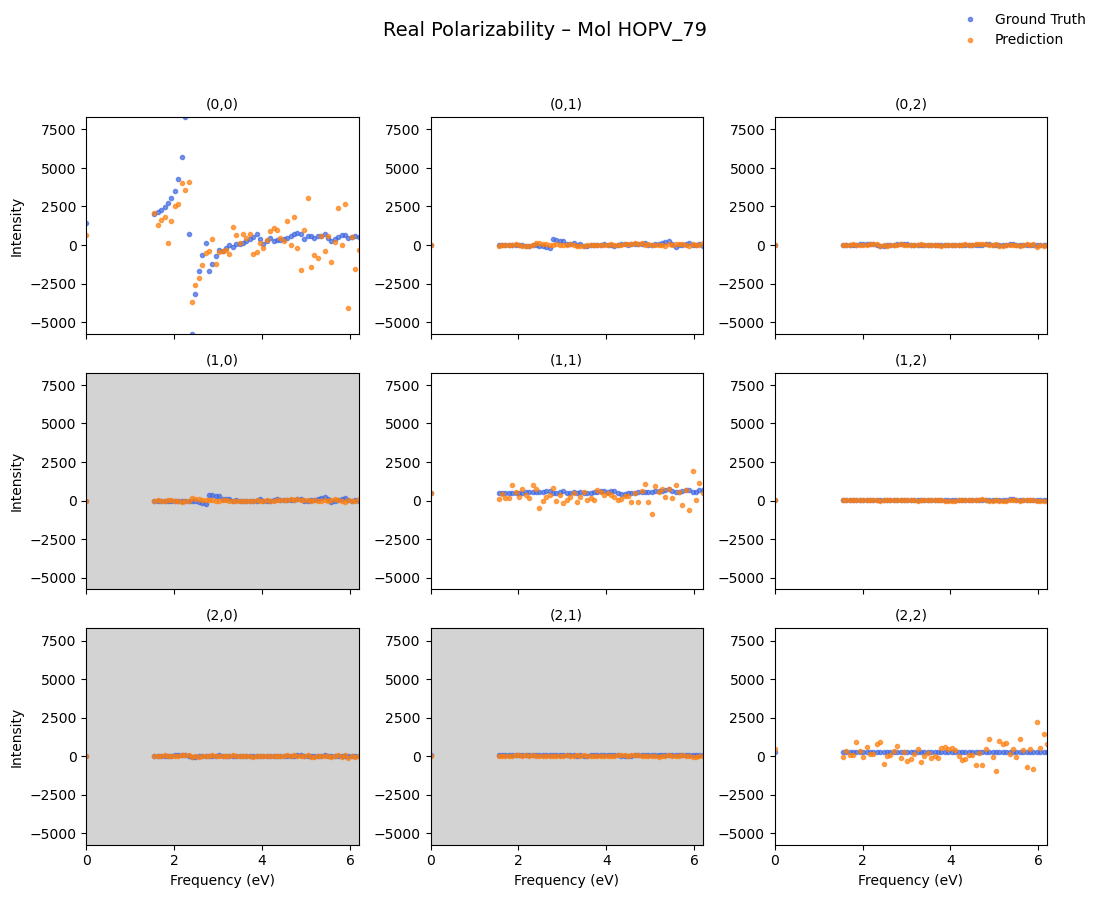

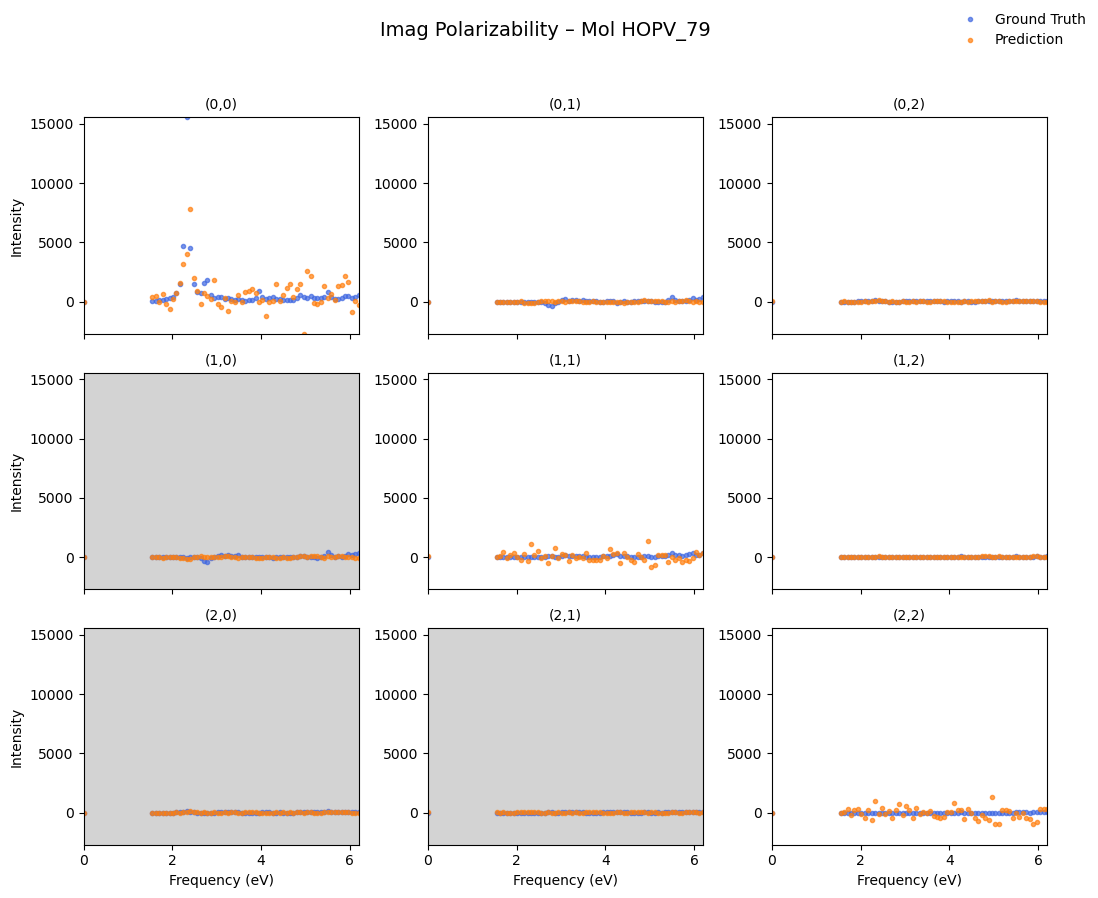

HOPV_319
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


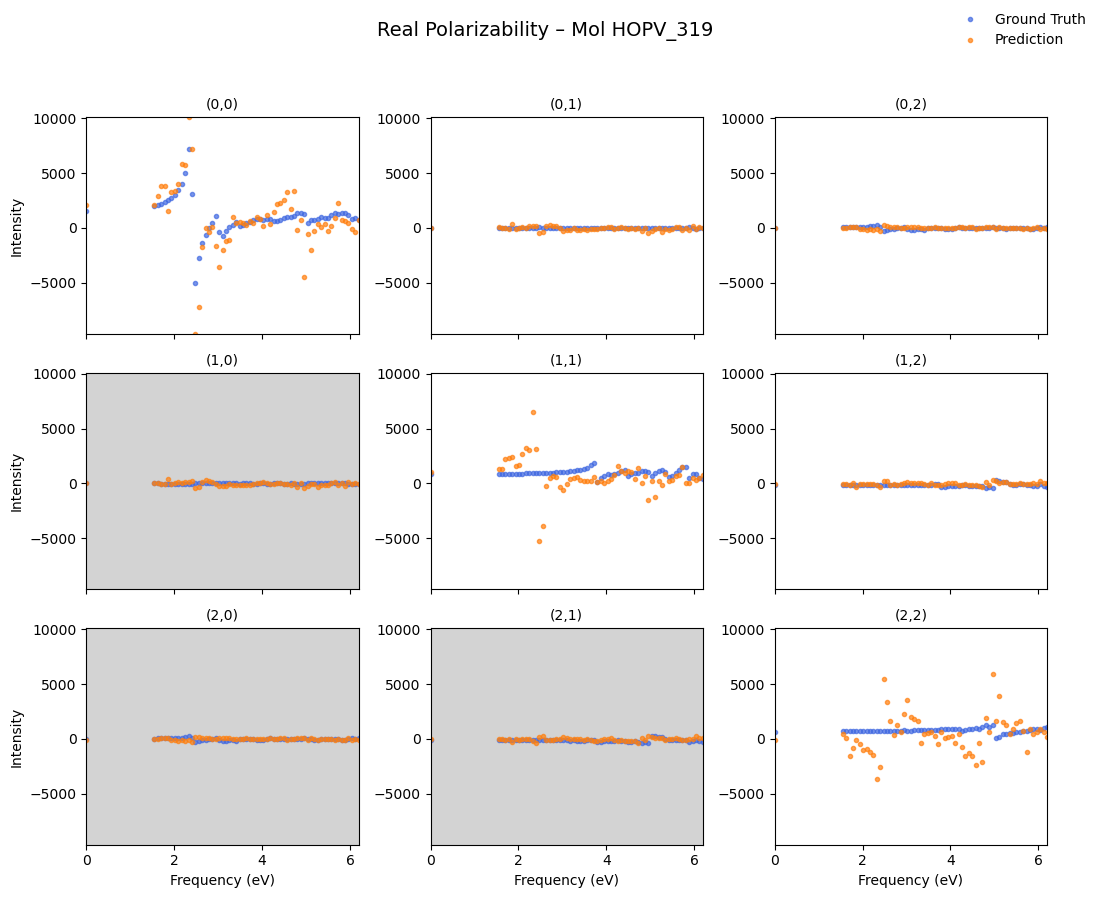

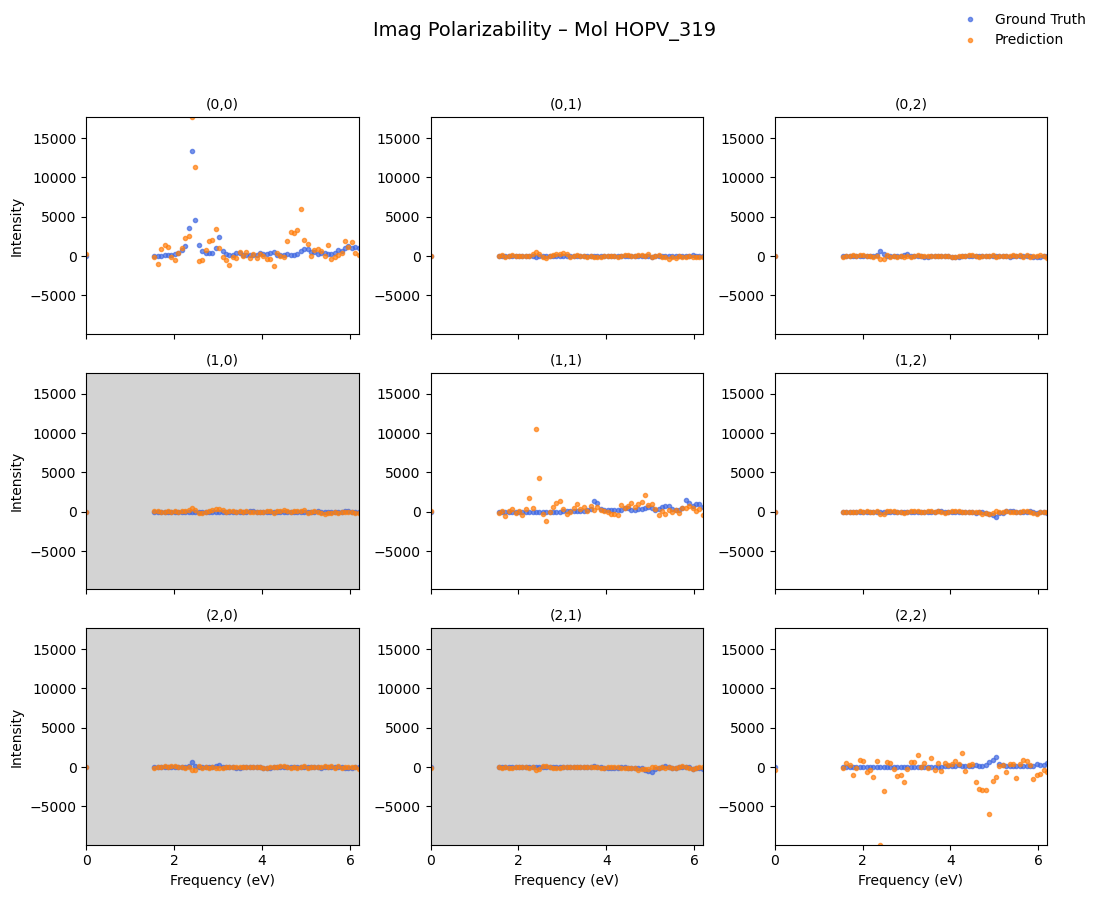

HOPV_174
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


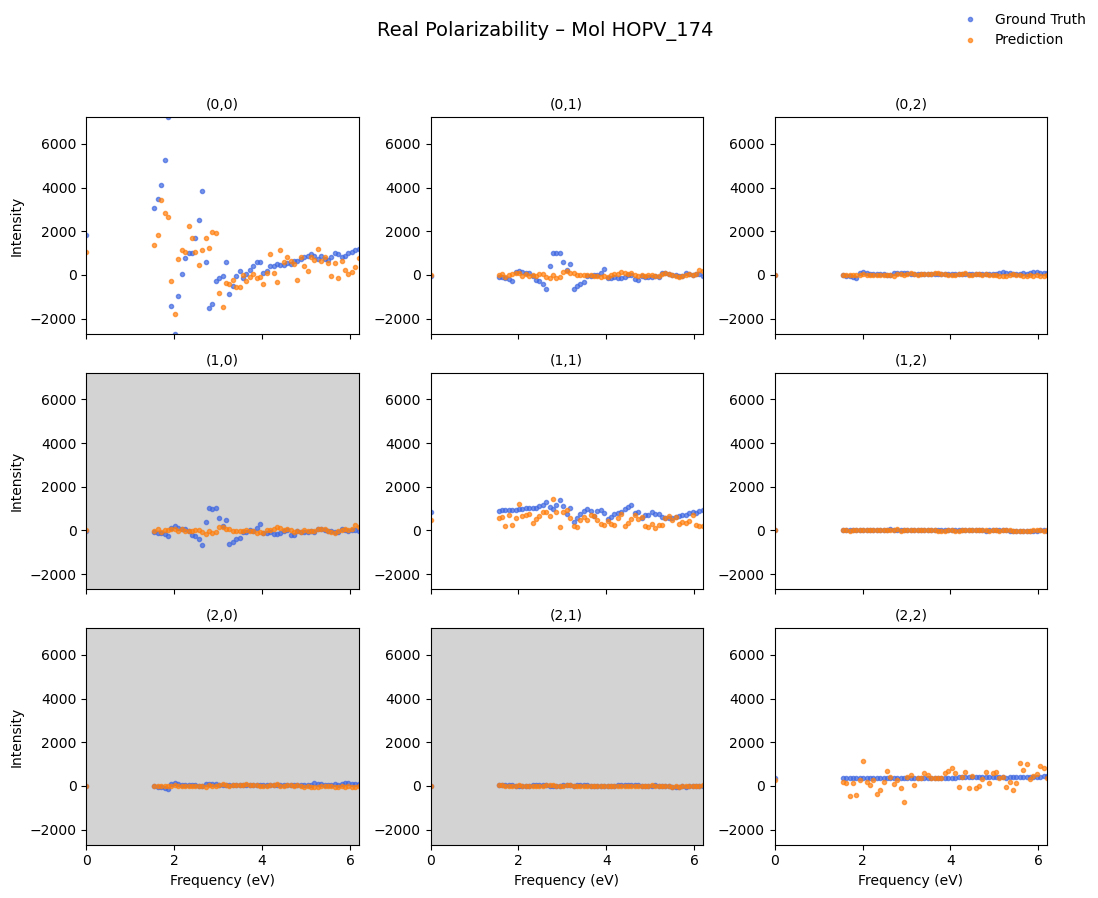

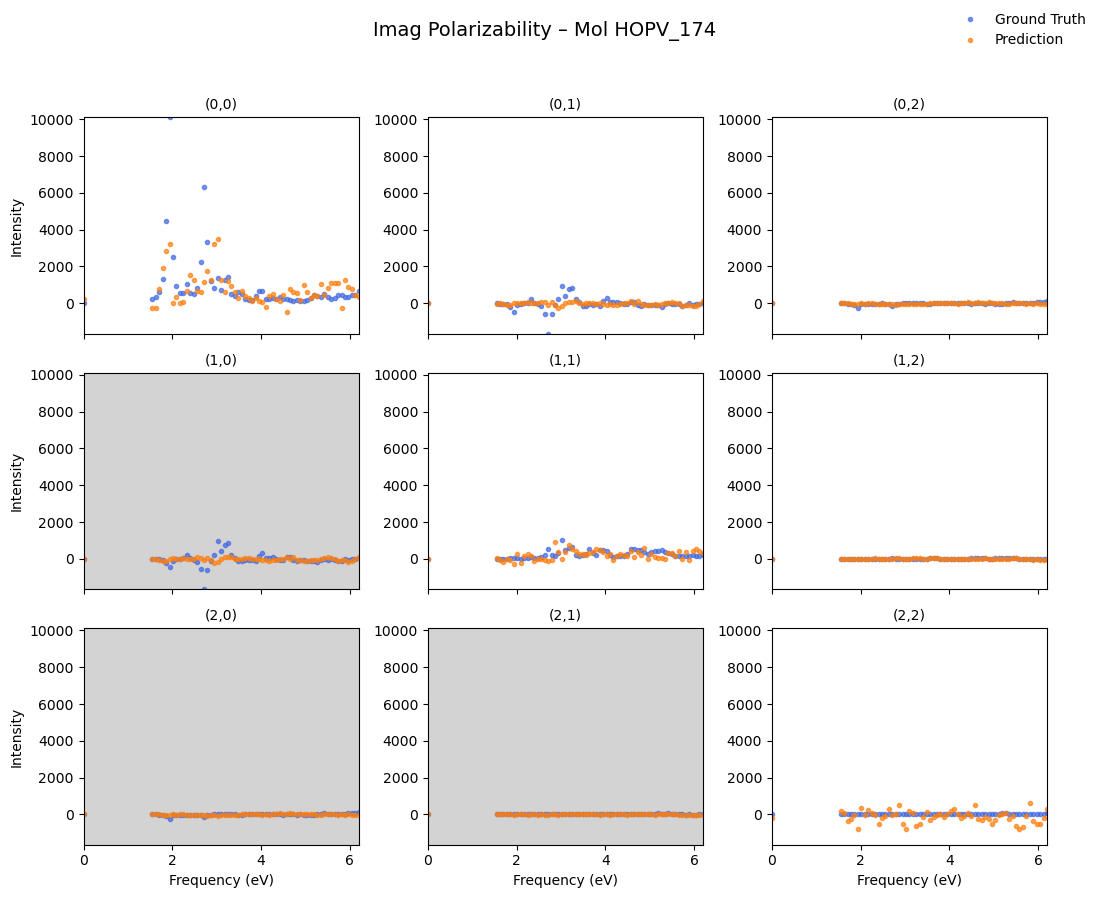

In [41]:
for i in range(4):
    data_entry = HOPV_val_datasets[i]  # Assuming you want to plot the first entry
    print(data_entry.idx)
    plot_polarizability_matrix_3x3(data_entry ,model_HOPV, out_dir="/media/maria/work_space/detanet-complex/images/OPT_pred_molcules")


## No Finetuning but direct Training!

In [43]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_HOPV = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=4, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=8,
                    rc=3.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params="/media/maria/work_space/dyn-detanet/code/trained_param/NO_finetune_spectra_80epochs_8batchsize_0_0006lr_3cutoff_4numblock.pth"
state_dict = torch.load(params)
model_HOPV.to(device)
model_HOPV.load_state_dict(state_dict=state_dict)


<All keys matched successfully>

HOPV_110
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


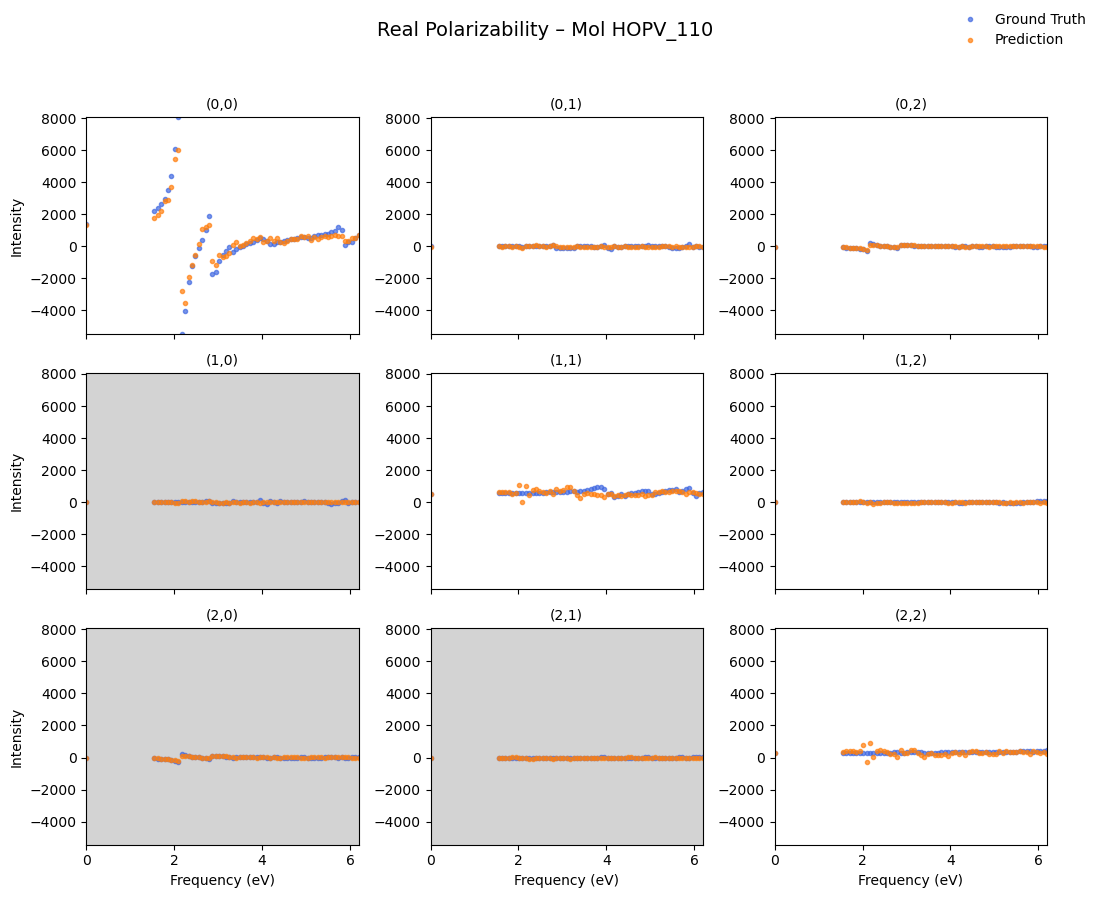

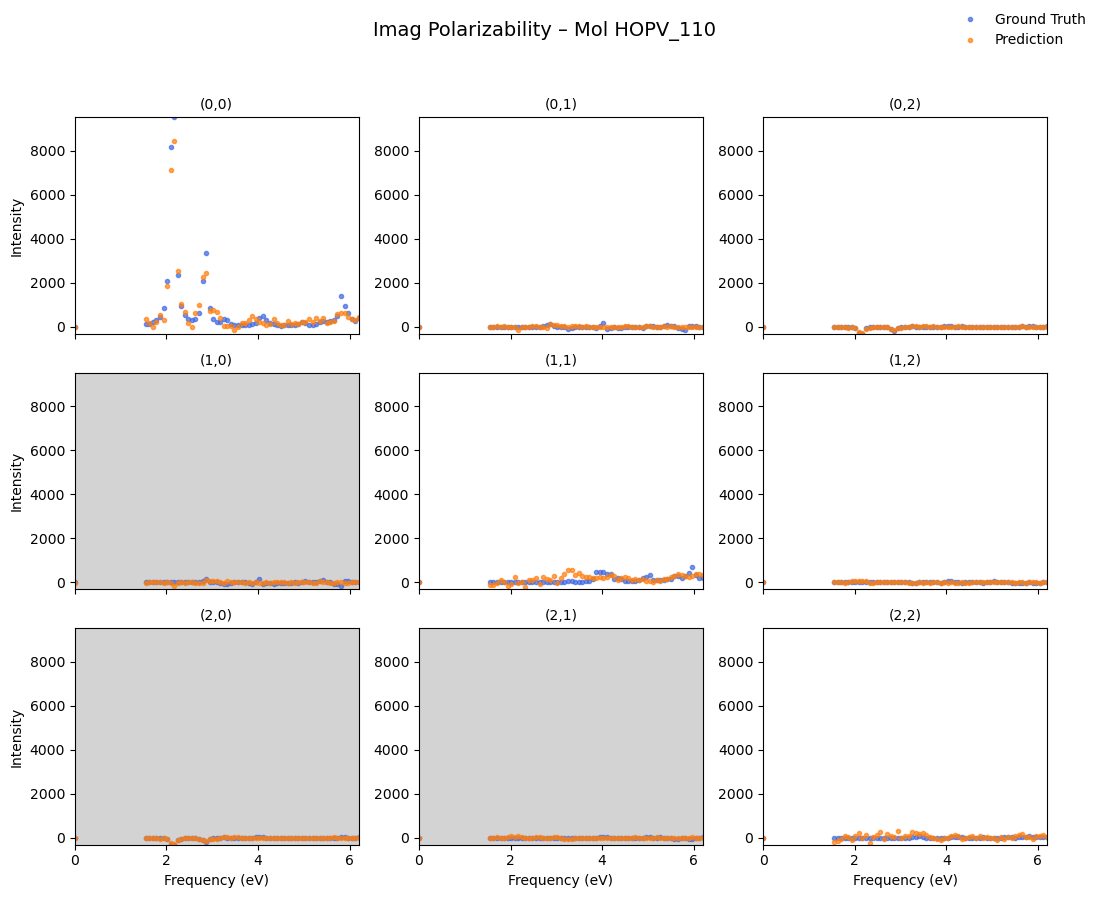

HOPV_79
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


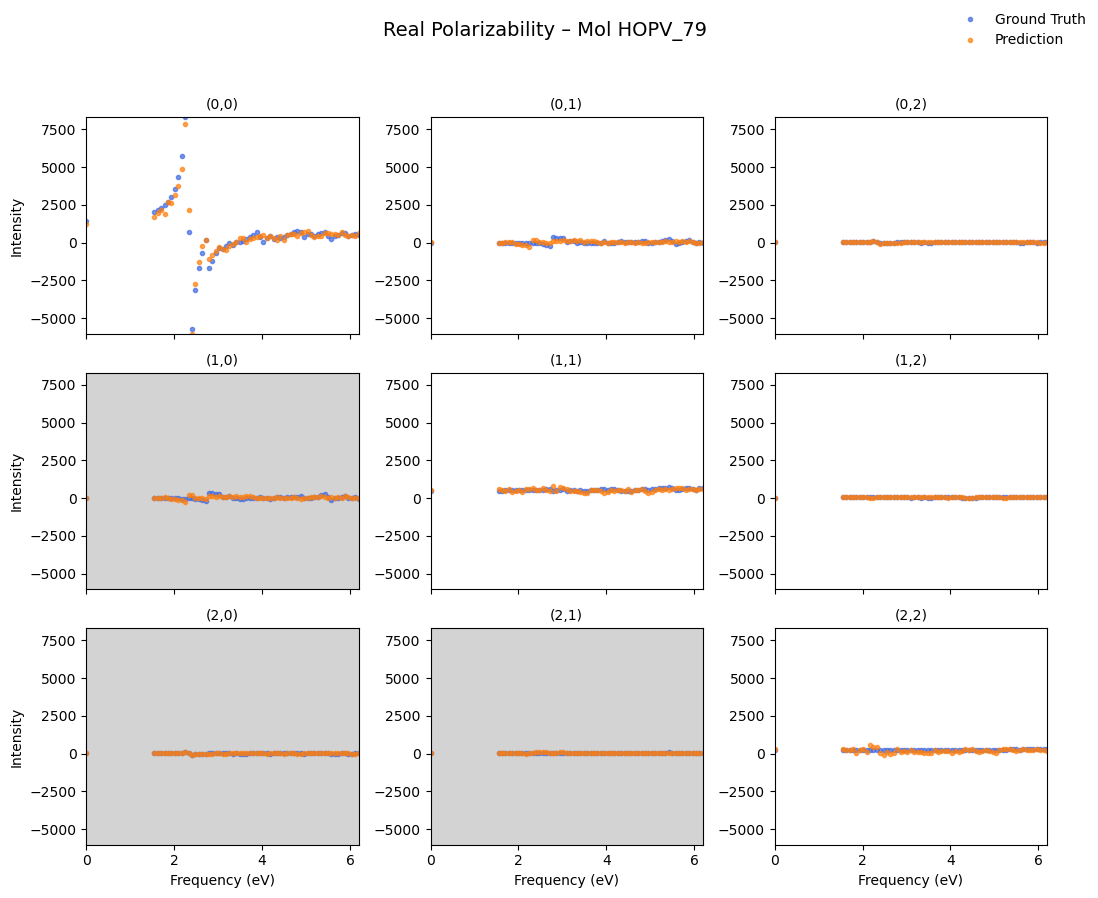

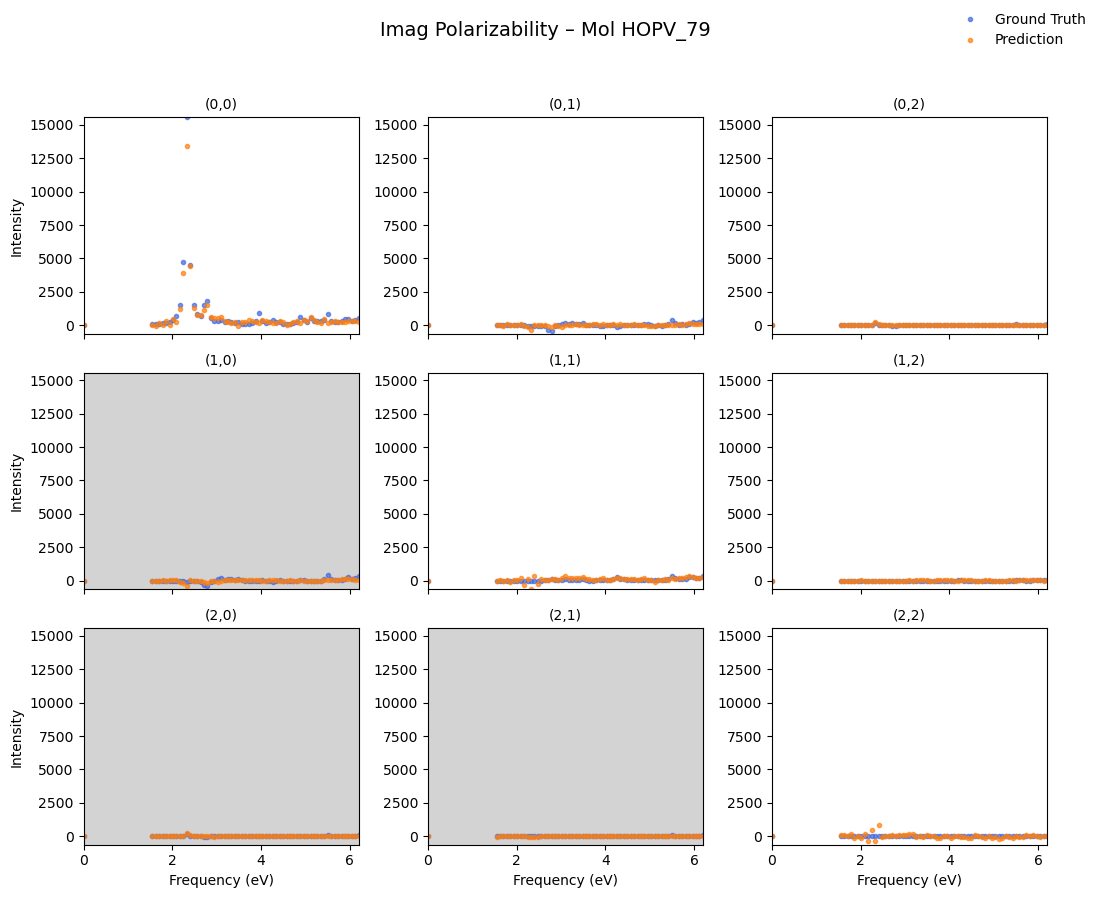

HOPV_319
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


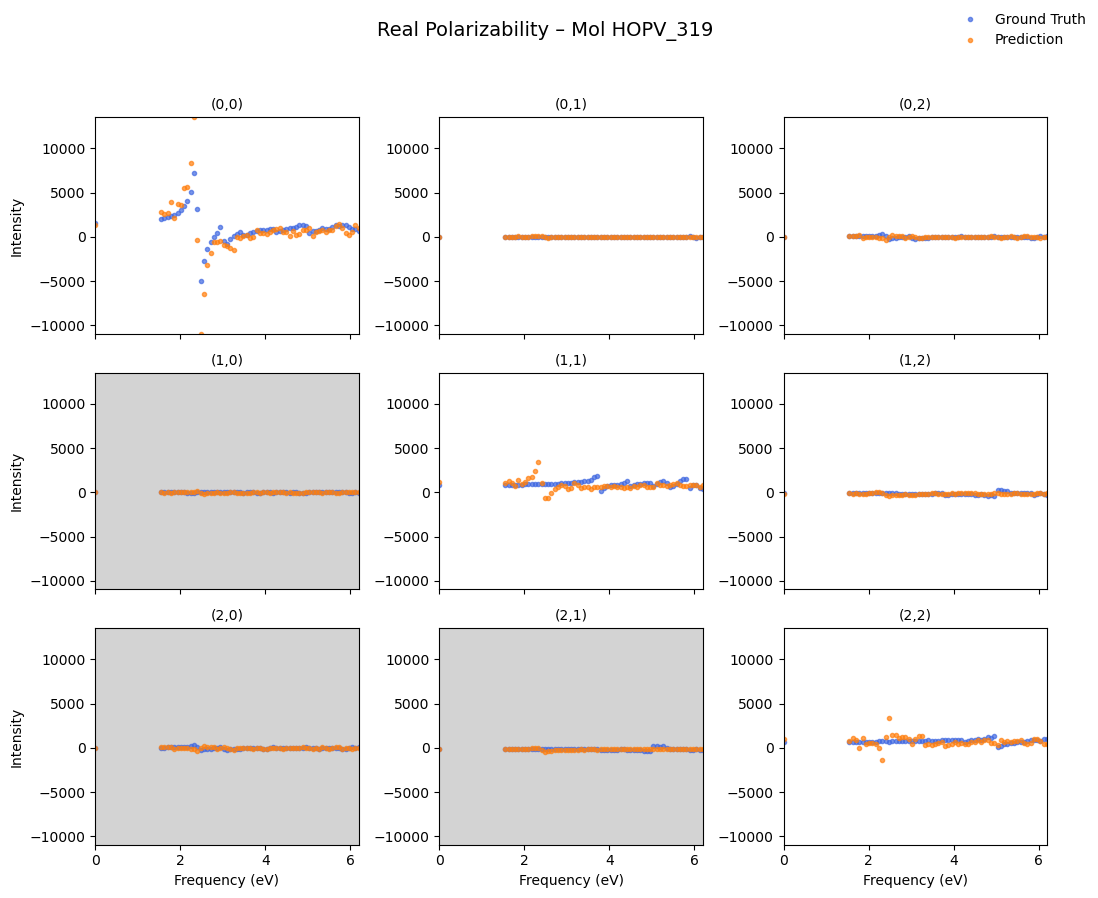

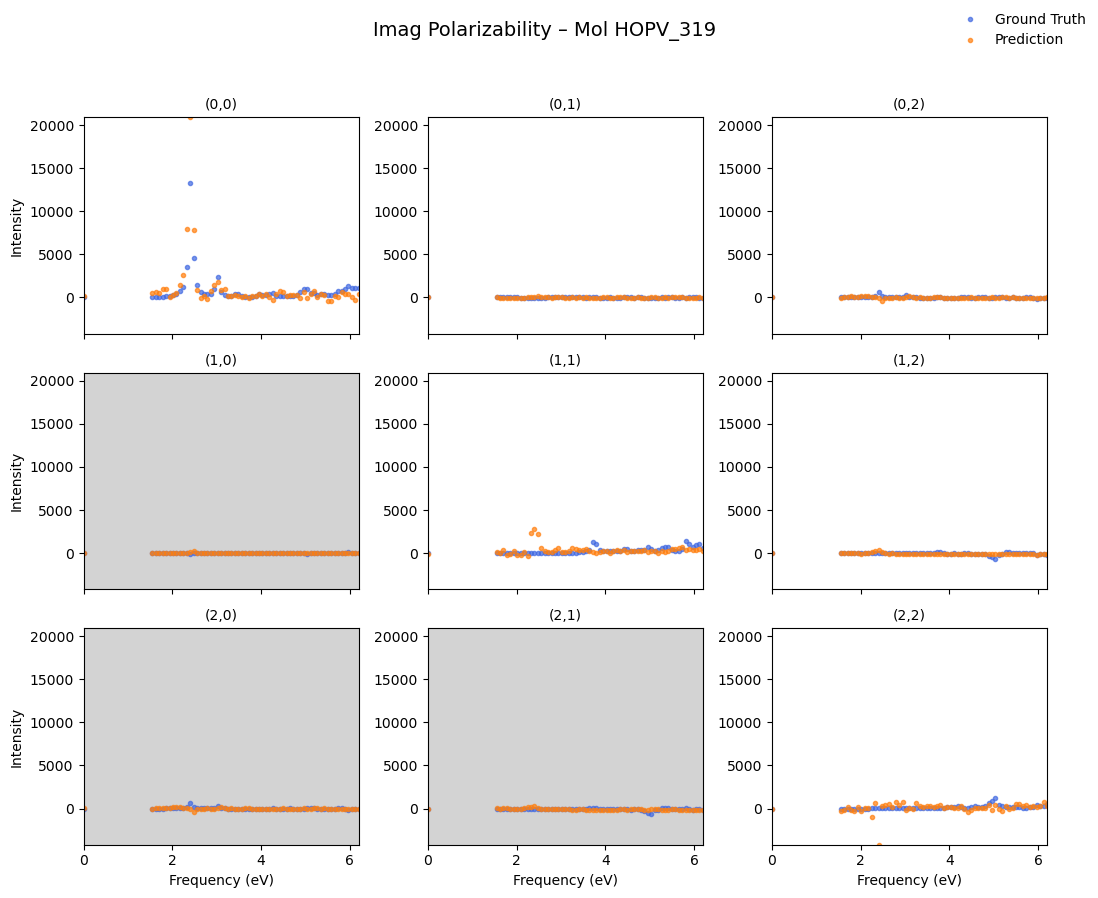

HOPV_174
GT shape: (62, 3, 3), Pred shape: (62, 3, 3)


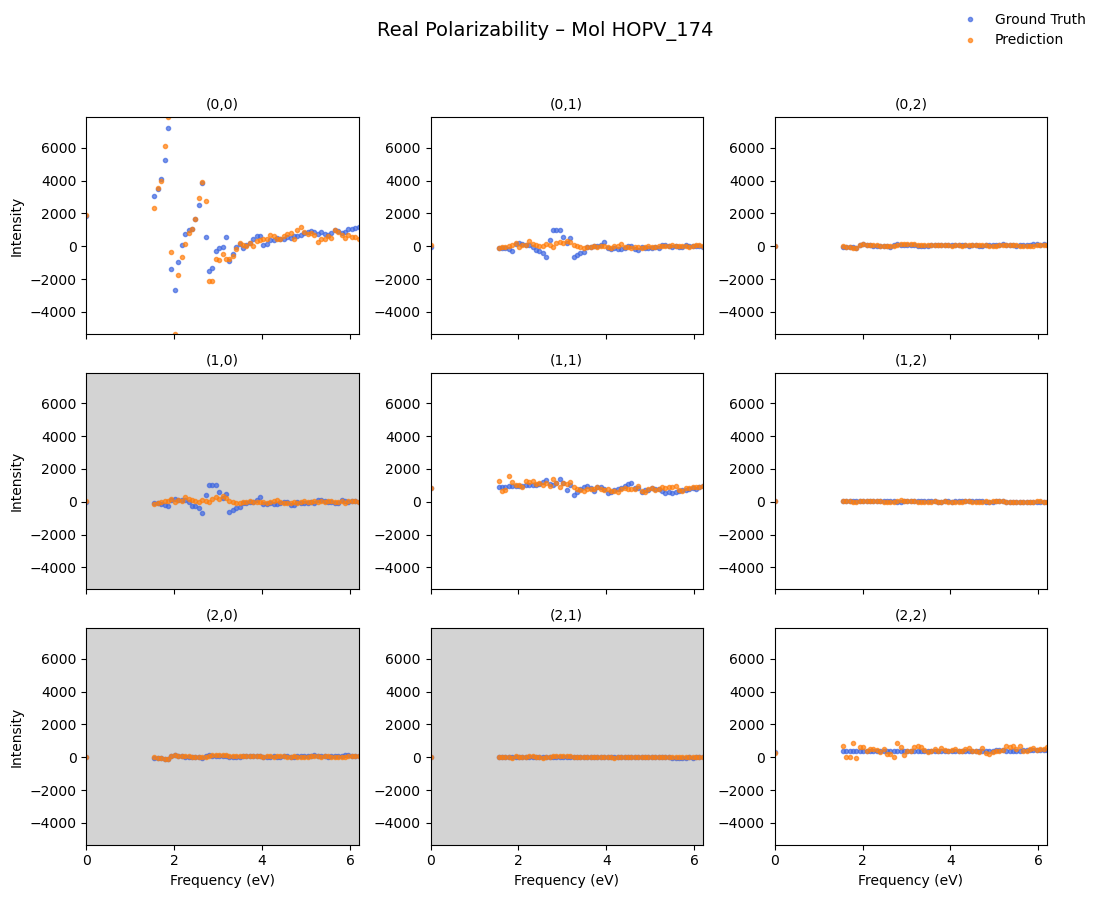

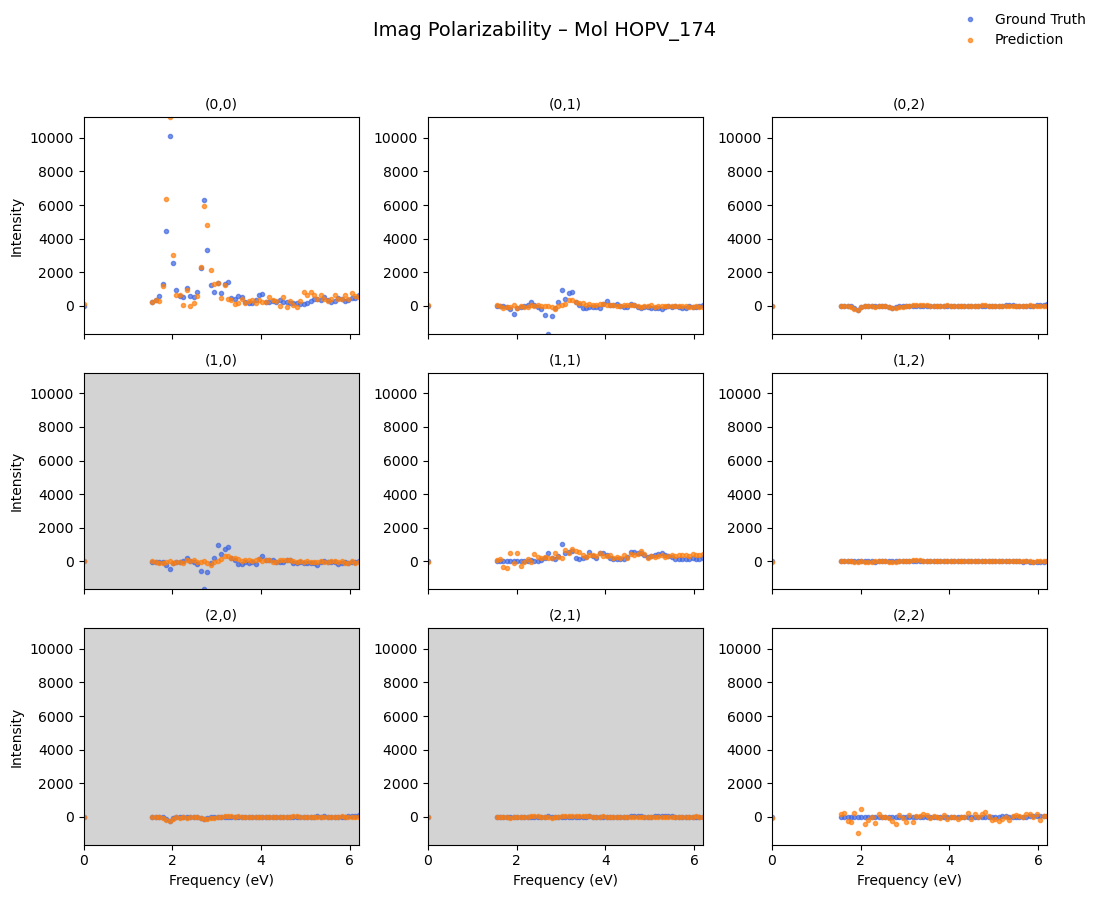

In [44]:
for i in range(4):
    data_entry = HOPV_val_datasets[i]  # Assuming you want to plot the first entry
    print(data_entry.idx)
    plot_polarizability_matrix_3x3(data_entry ,model_HOPV, out_dir="/media/maria/work_space/detanet-complex/images/OPT_pred_molcules")
